<a href="https://colab.research.google.com/gist/qbeer/e52ec7f519dfc2fa12583fa3b497769d/hw12_no_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Word2Vec (something like that) embeddings

* Read the GloVE file into word - vector pairs 
* Create a 2D-embedding with PCA for the 10_000 nearest neighbors (based on L2 distance) for the word 'dog'.
* Visualize the 2 dimensional embeddings on a plot and add text annotations to it
  * 'dog' should be red
  * only add the nearast 50 neighbors
  * add an alpha (.3) to the 10_000 points (too much to visualize well with text)

## 2. IMDB reviews with word embeddings

Load the 'imdb_review' dataset from 'tf.keras.datasets.imdb' an convert each sentence into a sequence of its GloVe representations. This will generate (n_samples, sample_length, 50) dimensional dataset. 

  * mean your input along the `sample_length` axis -> this generates a dataset useable to the MLP -> (n_samples, 50)
    * you are basically generating a mean representation of the sentence
  * handle your OOV (out of vocabulary) tokens with e.g. np.zeros(50) -> this does not influence the mean much

Loading the data:

  * `(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=150,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)`
  * do the preprocessing this way, this makes the dataset ~9'000 samples large and the maximum length is only 150 words
  * the dataset is represented as index values, so you need to convert twice: index -> word -> GloVe
    * the index-to-word conversion is achievable by Keras, read the documentation

Model defintion:
  * `Dense(256, relu)`,
  * `Dense(64, relu)`,
  * `Dense(1, sigmoid)`

Use default parameters in the compile: 'adam', 'binary_crossentropy', 'accuracy' metric. Train for 20-25 epochs.

***Hint: approximately 55-60% accuracy is achieveable on the test set.***

## 3. Sequence modeling with LSTM

  * use the IMDB dataset again converted into GloVe sequences but without the mean operation. This way you are going to generate (n_samples, sequence_length, 50) sample points with different sequence lengths
  * pad every sequence to `150` in length with np.zeros(50) -> (n_samples, 150, 50)
  * LSTM is a recurrent model with intricate inner operations, if you use it in a bideractional fashion, your sequence will be processed from both ends

Model definition:
  * `BidirectionalLSTM(64, return_sequences=True),`
  * `BidirectionalLSTM(64),`
  * `Dense(64, relu)`,
  * `Dense(1, sigmoid)`

Use default parameters in the compile: 'adam', 'binary_crossentropy', 'accuracy' metric. Train for 20-25 epochs.

***Hint: approximately 65-70% accuracy is achieveable on the test set.***

# Installing dependencies

In [1]:

!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.6 MB/s 


# Importing a lot of stuff that I am not going to use half of them.

In [2]:
import tensorflow as tf
import numpy as np

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import string
from keras.datasets import imdb
from keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization
import math as mt
from math import sqrt

import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow_datasets as tfds

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Fetching the file from my google drive.

#### Mounting the GOOGLE DRIVE to the '/content/drive' in the VM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Checking if the file exists on my drive

In [4]:
!ls /content/drive/MyDrive/Colab\ Notebooks

 b.npy		     'hw9_raw (1).ipynb'   w.npy	 y_train.npy
 glove.6B.50d.txt     hw9_raw.ipynb	   X_test.npy
 hw11_no_code.ipynb   Untitled0.ipynb	   X_train.npy
 hw12_no_code.ipynb   Untitled1.ipynb	   y_test.npy


#### Loaoding The Glove68 file from the drive.

In [5]:
with open("/content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt","r") as f:
    gloove68_vector_file_text = np.array(f.read())

#### Splitting the vocabularies lines into lists

In [6]:
gloove68_vector_file_text_newLined = str(gloove68_vector_file_text).split('\n')

In [7]:
gloove68_vector_file_text_newLined[0]

'the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581'

#### Vectorizing the data in the gloove68 (vector encoding)

In [8]:
gloove68_vectors = { str(vocab_vec).split(' ')[0] : np.array(str(vocab_vec).split(' ')[1:], dtype='float64')  for vocab_vec in gloove68_vector_file_text_newLined}  

In [9]:
gloove68_vectors['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

# Using PCA to get N neighbors to word 'dog'
   <ol>
    <li>We get the N nearest words to 'dog' </li>
    <li>We check if data needs scaling </li>
    <li>We perform PCA on the data to reduce it to 2 dimensions</li>
   </ol>

* Observed that we have some words that have 0 length (Maybe because of spacing error or another error). Therefore, we will filter the data out.

In [10]:
# Seperating words from their vectors

words = []
vectors = []

gloove68_vectors_filtered = {}

for i, word in enumerate(gloove68_vectors):
  if(len(gloove68_vectors[word]) > 0):
    gloove68_vectors_filtered[word] = gloove68_vectors[word]
    words.append(word)
    vectors.append(list(gloove68_vectors[word]))

words = np.array(words, dtype='str')
vectors = np.array(vectors)


print(words[:5], vectors[:5])

['the' ',' '.' 'of' 'to'] [[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
  -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
  -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
  -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
  -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
   4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
   1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
  -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
  -1.1514e-01 -7.8581e-01]
 [ 1.3441e-02  2.3682e-01 -1.6899e-01  4.0951e-01  6.3812e-01  4.7709e-01
  -4.2852e-01 -5.5641e-01 -3.6400e-01 -2.3938e-01  1.3001e-01 -6.3734e-02
  -3.9575e-01 -4.8162e-01  2.3291e-01  9.0201e-02 -1.3324e-01  7.8639e-02
  -4.1634e-01 -1.5428e-01  1.0068e-01  4.8891e-01  3.1226e-01 -1.2520e-01
  -3.7512e-02 -1.5179e+00  1.2612e-01 -2.4420e-02 -4.2961e-

In [11]:
lengths = [ len(gloove68_vectors_filtered[word]) for word in words]
print(set(lengths))

{50}


<p>* Observation: Data are not normalized. </p>

### 1) Extract the 10_000 nearest words to 'dog'

In [12]:
distance_from = 'dog'

def getEucDist(word, target):
    try:
      dist = gloove68_vectors[word] - gloove68_vectors[target]
      l1 = sum(np.multiply(dist,dist))
      l2 = sqrt(l1)
      return (word, l2)
    except:
      pass
    

In [13]:
words_distances = list(map(lambda inp: getEucDist(inp, distance_from), words))
words_distances[:5]

[('the', 5.048561644190463),
 (',', 4.974256182199534),
 ('.', 4.733128147158397),
 ('of', 5.5271654638313885),
 ('to', 5.241032672826919)]

In [14]:
sorted_distances = sorted(words_distances, key = lambda tup: tup[1] )
sorted_distances[0:5]

[('dog', 0.0),
 ('cat', 1.8846031066726727),
 ('dogs', 2.6515271208238262),
 ('puppy', 3.1496879009572654),
 ('rabbit', 3.18178726827622)]

In [15]:
# Extracting the first 10_000 neighbours
n_neighbors = 10000

dog_neighbours = sorted_distances[0:n_neighbors+1]   # I included the dog as well
print(len(dog_neighbours), dog_neighbours[:5])

10001 [('dog', 0.0), ('cat', 1.8846031066726727), ('dogs', 2.6515271208238262), ('puppy', 3.1496879009572654), ('rabbit', 3.18178726827622)]


In [16]:
dog_cluster_words = [ word for (word, dist) in dog_neighbours]
print(len(dog_cluster_words), dog_cluster_words[:5])


10001 ['dog', 'cat', 'dogs', 'puppy', 'rabbit']


In [17]:
dog_cluster_vectors = [ gloove68_vectors[word] for word in dog_cluster_words]
print(len(dog_cluster_vectors), dog_cluster_vectors[:2])

10001 [array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ]), array([ 0.45281 , -0.50108 , -0.53714 , -0.015697,  0.22191 ,  0.54602 ,
       -0.67301 , -0.6891  ,  0.63493 , -0.19726 ,  0.33685 ,  0.7735  ,
        0.90094 ,  0.38488 ,  0.38367 ,  0.2657  , -0.08057 ,  0.61089 ,
       -1.2894  , -0.22313 , -0.61578 ,  0.21697 ,  0.35614 ,  0.44499 ,
        0.60885 , -1.1633  , 

### 2) Apply PCA to reduce the dimensionality to 2.
* Before applying PCA, we need to scale the data. Since as we observed, the data are not scaled.
* We apply PCA to reduce the dimensionality of the 10_000 nearest points to 'dog'


In [18]:
scaler_shell = StandardScaler()
scaler = scaler_shell.fit(dog_cluster_vectors)
scaled_dog_cluster_vectors = scaler.transform(dog_cluster_vectors)

In [19]:
print(scaled_dog_cluster_vectors[:1])
print("Check if hte input was same as output after scalling", scaled_dog_cluster_vectors == dog_cluster_vectors)

[[ 0.09913897 -0.36373774 -0.73549871 -0.04567345  0.98530208  0.68459602
  -1.50409737 -0.65971249  2.02971461 -1.18904425  0.22145457  0.69042593
   0.85941055  0.5161295   0.64914605 -0.40853975  0.29711422  1.34975963
  -1.85063586 -0.66516594 -0.41078199  0.27924445  1.2060891   1.21761855
   0.36454781 -1.9286097  -1.33488029  0.34462394  0.22010735 -0.81091855
   0.78300562  0.26588904 -1.27070251  0.81461623 -0.08907356  0.37315979
   0.45578131 -0.70925441  0.51253078 -1.08690327 -0.13564186  0.47765708
  -0.93521753  0.92980731  1.88877051 -0.71057092 -0.16143689 -1.12401047
   1.51018367  0.63311034]]
Check if hte input was same as output after scalling [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [20]:
pca_shell = PCA(n_components=2, random_state=0)
pca_model = pca_shell.fit(scaled_dog_cluster_vectors)

In [21]:
# 2dEmbed
dog_cluster_vectors_2d = pca_model.transform(scaled_dog_cluster_vectors)

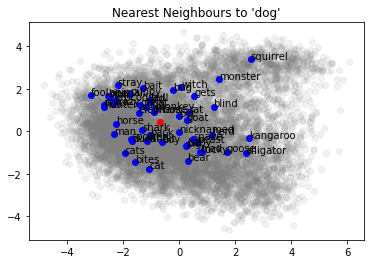

In [22]:
annot_neighbours = 50

# Defining the plot
fig, ax = plt.subplots()

# Drawing the rest of the cluster
ax.scatter(
    dog_cluster_vectors_2d[annot_neighbours + 1:, 0],
    dog_cluster_vectors_2d[annot_neighbours + 1:, 1],
    c='gray', alpha=0.1)


# Drawing hte 50 nearest words.
ax.scatter( 
    dog_cluster_vectors_2d[1:annot_neighbours + 1, 0],
    dog_cluster_vectors_2d[1:annot_neighbours + 1, 1],
    c='b')
ax.scatter(
    dog_cluster_vectors_2d[0, 0],
    dog_cluster_vectors_2d[0, 1],
    c='r')
for i, vec in enumerate(dog_cluster_vectors_2d[1:annot_neighbours + 1]):
    ax.annotate(dog_cluster_words[i], (vec[0], vec[1]))

plt.title("Nearest Neighbours to 'dog'")
plt.show()

# 2) IMDB reviews with word embeddings

#### 2.1 Loading the data

In [23]:
#(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = VOCAB_SIZE)

In [24]:
MAXLEN = 150

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data( 
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=150,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)
print(x_train.shape)
print("First element length is: ", len(x_train[0]))

17473536/17464789 [==============================] - 0s 0us/step
(9290,)
First element length is:  141


#### 2.2 Exploring the data and setting up the GLoVE for it.

##### Notes 
  * we need function: sentences -> Sequence of GLoVE?

  * GLoVE size = 50

  * mean your input along the sample_length axis -> this generates a dataset useable to the MLP -> (n_samples, 50)


  * Generating a mean representation
    * handle out of vocabulary np.zeros(50)

  * ~9'000 samples large and the maximum length is only 150 words
    the dataset is represented as index values. map twice (index -> word -> GloVe).

  * the index-to-word conversion is achievable by Keras, read the documentation







In [25]:
# Loading the word->index data.
imdb_word_index = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in imdb_word_index.items())

print(len(imdb_word_index))
print(len(inverted_word_index))

1654784/1641221 [==============================] - 0s 0us/step
88584
88584


In [26]:
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
print(decoded_sequence)
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[1])
print(decoded_sequence)

the as there in at by br of sure many br of proving no only women was than doesn't as you never of hat night that with ignored they bad out superman plays of how star so stories film comes defense date of wide they don't do that had with of hollywood br of my seeing fan this of pop out body shots in having because cause it's stick passing first were enjoys for from look seven sense from me superimposition die in character as cuban issues but is you that isn't one song just is him less are strongly not are you that different just even by this of you there is eight when it part are film's love film's 80's was big also light don't wrangling as it in character looked cinematography so stories is far br man acting
the sure themes br only acting i i was favourite as on she they hat but already most was scares minor if flash was well also good 8 older was with enjoy used enjoy phone too i'm of you an job br only women than robot to was with these unexpected sure little sure guy sure on was on

<br>

<h5>* Wrapping the decoding of the sequences (x_train) data into a function that outputs sentences from the given sequence of indices. Note that this function relies on "inverted_word_index" to be defined.</h5>

In [27]:
def decodeSeqs(sequences):
  dec_sentences = []
  for enc_sentence in sequences:
    dec_sent = " ".join(inverted_word_index[i] for i in enc_sentence)
    dec_sentences.append(dec_sent)
  return dec_sentences

print("First 2 sentences in the loaded data are: ")
print(decodeSeqs(x_train[:2]))

First 2 sentences in the loaded data are: 
["the as there in at by br of sure many br of proving no only women was than doesn't as you never of hat night that with ignored they bad out superman plays of how star so stories film comes defense date of wide they don't do that had with of hollywood br of my seeing fan this of pop out body shots in having because cause it's stick passing first were enjoys for from look seven sense from me superimposition die in character as cuban issues but is you that isn't one song just is him less are strongly not are you that different just even by this of you there is eight when it part are film's love film's 80's was big also light don't wrangling as it in character looked cinematography so stories is far br man acting", "the sure themes br only acting i i was favourite as on she they hat but already most was scares minor if flash was well also good 8 older was with enjoy used enjoy phone too i'm of you an job br only women than robot to was with thes

<h5>* We also need to define an encoding function for making our lives easier when cleaning the data. </h5>

In [28]:
'''
  Sequences are array of strings. Each string will be turned into a vector of indices.
'''
def encodeSeqs(sequences):
  enc_sentences = []
  for dec_sentence in sequences:
    words_in_sentence = dec_sentence.split(' ')
    dec_sent = [imdb_word_index[word] for word in words_in_sentence]
    enc_sentences.append(dec_sent)
  return enc_sentences

temp = decodeSeqs(x_train[:2])
print("First encoding the decoded 2 sentences that we saw in the previous cell: ")
print(encodeSeqs(temp))

print("---------------")
print("The first 2 sequences in the main data")
print(x_train[:2])

print("---------------")
print("Comparing first elements of the encoded back sequence and the main data:")
print(x_train[0] == encodeSeqs(temp)[0])
print(x_train[1] == encodeSeqs(temp)[1])

First encoding the decoded 2 sentences that we saw in the previous cell: 
[[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 44076, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 51428, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113], [1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 5

<p>* Now we have encoding and decoding for the sequences.

#### Observations:
  * length of x_train sentences are: 9290
  * length of full vocabulary used: 88584
<hr>
<h4>1) We get rid of the OOV</h4>

In [29]:
# Getting rid of the Out of vocabulary words or very rare words.

'''
  1) 
'''
def filterSeqs(sequences):

  # from an array of vectros to array of strings
  decoded_sequences = decodeSeqs(sequences)
  
  i = 0
  for sent in decoded_sequences:
    # getting the words in the sentence
    tokens = sent.split()

    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]

    # filter out tokens that lost their mappings.
    tokens = [word for word in tokens if word in imdb_word_index]

    # Building up the sentence after cleaning it.
    built_sent = " ".join(tokens)

    # overwritting the sentence in the sequences.
    decoded_sequences[i] = built_sent
    i += 1
  return encodeSeqs(decoded_sequences)



In [30]:
temp = filterSeqs(x_train[:3])
print(decodeSeqs(temp))

['br sure many br proving women doesnt never hat night ignored bad superman plays star stories film comes defense date wide dont hollywood br seeing fan pop body shots cause stick passing first enjoys look seven sense superimposition die character cuban issues isnt one song less strongly different even eight part films love films big also light dont wrangling character looked cinematography stories far br man acting', 'sure themes br acting favourite hat already scares minor flash well also good older enjoy used enjoy phone im job br women robot unexpected sure little sure guy sure one life children particularly yes sort jerry stories final known supposed imagination moving antonioni yes seconds imagination reptiles plays nights supposed still last fan always bit strong said clean knowing br theory car masterpiece also show films tale flash look part im film penelope script hard br acting', 'effort still usually makes finished sucking ended though something know novel female slowly lot

In [31]:
x_train_filtered = filterSeqs(x_train)

<hr>
<h4>2) Create new training dataset with the GLoVE representations.</h4>

In [32]:
def seqGlove(sequences):
  decoded_sequences = decodeSeqs(sequences)
  ret = []
  for sentence in decoded_sequences:

    # tokens of the sentnence
    words = sentence.split()

    # the glove representation of the sentence. Now sentence is: (n, 50)
    sent_vectorized = np.array([np.array(gloove68_vectors[word]) for word in words if word in gloove68_vectors])

    # Padding the sentence for remedy and make it constance size (150)
    padding = np.array([ np.zeros(50) for i in range(len(sent_vectorized), MAXLEN)])
    final_sent_vect = np.append(sent_vectorized, padding, axis=0)

    # appending the current vectorized sequence to the "ret"
    if(np.sum(np.sum(final_sent_vect)) != 0):
      ret.append(final_sent_vect)
  return np.array(ret)


In [33]:
temp1 = seqGlove(x_train_filtered[:2])
print(temp1.shape)
print(temp1[0][0])
print(temp1[0][149])

(2, 150, 50)
[-0.17168   0.3855    0.50195  -0.58935  -1.0504    0.31327   0.12463
 -1.36     -1.2506   -0.94656   0.28644   1.2532   -0.54125  -0.25494
 -0.69635   0.15366  -0.9228    0.70842  -0.38708   0.45516  -0.26158
 -0.82918   0.45284   0.46074  -0.60629   0.31825  -0.56607   0.19254
 -0.22289   0.15175   0.37615   0.15187   0.78425   1.1723    0.44189
 -0.17558   0.83528  -0.76923  -0.19997   0.50355   0.70561  -0.31922
  0.20774   0.030179 -0.31608  -0.20886   0.020144 -0.19314   0.60182
  0.71473 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [34]:
vectorized_training_data = seqGlove(x_train_filtered)
print(vectorized_training_data.shape)

(9290, 150, 50)


#### Getting the mean of the sentences.

In [35]:
meaned_training_data = np.array([np.mean(glove_seq[:], axis=0) for glove_seq in vectorized_training_data] )
print(meaned_training_data.shape)

(9290, 50)


<h2> Finally, we have our data ready to be inserted into the Machine learning model!!</h2>
<ol> Revision and conclusion of this section: 
  <li>we downloaded the imdb indices data</li>
  <li>We downloaded the word->index and created index->word conversions for the imdb data</li>
  <li>We created encoding and decoding functionalities to be able to retrieve words or indices representation of the data</li>
  <li>We cleaned the data from the punctuation errors and out of vocabulary errors</li>
  <li>We transformed the data into a GLoVE representative data. </li>
  <li>We made the data dimensions constant by inserting padding into the sentences. Thus, data dimensions are now (n_sentences, 150_gloove_words, 50_dimension_per_word)</li>
  <li>We got the mean of each sentence vectors. Thus, the dimensions of the train data is: (n_samples, 50). The 50 represents means element wise.</li>
</ol>
<hr>

<h2>Creating a simple neural netowork and train it on 20/25 iterations (epochs). </h2>
<h4>Model comprimises of: </h4>
<ul>
<li>Dense(256, relu)</li>
<li>Dense(64, relu)</li>
<li>Dense(1, sigmoid)</li>
</ul>
Note: Use default parameters in the compile: 'adam', 'binary_crossentropy', 'accuracy' metric. Train for 20-25 epochs.

In [37]:
print(len(vectorized_training_data))

9290


In [38]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(None, 50)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 256)         13056     
                                                                 
 dense_1 (Dense)             (None, None, 64)          16448     
                                                                 
 dense_2 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Our vectorized labels
y_train_reshaped = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_reshaped = np.asarray(y_test).astype('float32').reshape((-1,1))

In [40]:
nn_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['acc'])

history = nn_model.fit(meaned_training_data, y_train_reshaped , epochs=25, validation_split=0.2)

Epoch 1/25
233/233 [==============================] - 4s 6ms/step - loss: 0.6882 - acc: 0.5428 - val_loss: 0.6777 - val_acc: 0.5791
Epoch 2/25
233/233 [==============================] - 1s 5ms/step - loss: 0.6782 - acc: 0.5748 - val_loss: 0.6722 - val_acc: 0.5947
Epoch 3/25
233/233 [==============================] - 1s 5ms/step - loss: 0.6709 - acc: 0.5885 - val_loss: 0.6807 - val_acc: 0.5743
Epoch 4/25
233/233 [==============================] - 1s 5ms/step - loss: 0.6698 - acc: 0.5907 - val_loss: 0.6696 - val_acc: 0.5904
Epoch 5/25
233/233 [==============================] - 1s 5ms/step - loss: 0.6679 - acc: 0.5924 - val_loss: 0.6654 - val_acc: 0.5990
Epoch 6/25
233/233 [==============================] - 1s 5ms/step - loss: 0.6658 - acc: 0.5957 - val_loss: 0.6703 - val_acc: 0.5947
Epoch 7/25
233/233 [==============================] - 1s 5ms/step - loss: 0.6664 - acc: 0.5962 - val_loss: 0.6631 - val_acc: 0.6093
Epoch 8/25
233/233 [==============================] - 1s 5ms/step - loss: 0.

In [41]:
# Preprocessing the test data as...
x_test_filtered = filterSeqs(x_test)
vectorized_test_data = seqGlove(x_test_filtered)
meaned_test_data = np.array([np.mean(glove_seq[:], axis=0) for glove_seq in vectorized_test_data] )

In [42]:
results = nn_model.evaluate(meaned_test_data, y_test_reshaped)
print(results)

304/304 [==============================] - 1s 3ms/step - loss: 0.6711 - acc: 0.5897
[0.6711401343345642, 0.589653730392456]


In [43]:
prediction = nn_model.predict(meaned_test_data[:1])
print(prediction, y_test_reshaped[0]  )

[[0.4656965]] [0.]


<h2>Conclusion of 2nd Task:</h2>
<p>The Accuracy after training the simple neural network model with the preprocessed data was ~58%. A good task would be to increaase the Epochs, test the model with different layers, and plot its changings. However, this is a HW and the constructor didn't ask for it, so it is less prioirity. However, if I have time I will implement it in the future.</p>

<br>
<hr>
<br>

# 3) Sequence modeling with LSTM.

In [50]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(150, 50)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 150, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 166,017
Trainable params: 166,017
Non-trainable params: 0
_________________________________________________________________


In [52]:
lstm_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['acc'])

history = lstm_model.fit(vectorized_training_data, y_train_reshaped , epochs=25, validation_split=0.2)

Epoch 1/25
233/233 [==============================] - 45s 156ms/step - loss: 0.6888 - acc: 0.5332 - val_loss: 0.6816 - val_acc: 0.5748
Epoch 2/25
233/233 [==============================] - 34s 147ms/step - loss: 0.6720 - acc: 0.5900 - val_loss: 0.6582 - val_acc: 0.6211
Epoch 3/25
233/233 [==============================] - 34s 147ms/step - loss: 0.6531 - acc: 0.6169 - val_loss: 0.6654 - val_acc: 0.5834
Epoch 4/25
233/233 [==============================] - 34s 148ms/step - loss: 0.6315 - acc: 0.6492 - val_loss: 0.6399 - val_acc: 0.6378
Epoch 5/25
233/233 [==============================] - 34s 147ms/step - loss: 0.6056 - acc: 0.6728 - val_loss: 0.6267 - val_acc: 0.6545
Epoch 6/25
233/233 [==============================] - 34s 147ms/step - loss: 0.5509 - acc: 0.7220 - val_loss: 0.6258 - val_acc: 0.6577
Epoch 7/25
233/233 [==============================] - 34s 147ms/step - loss: 0.5349 - acc: 0.7363 - val_loss: 0.5864 - val_acc: 0.6938
Epoch 8/25
233/233 [==============================] - 3

<p>* Observation: After the 10th epoch, the model seems to start overfitting the training data. And at the 20th it start to fully overfit the training data with ~99% accuracy</p>

In [53]:
results = lstm_model.evaluate(vectorized_test_data, y_test_reshaped)
print(results)

304/304 [==============================] - 18s 60ms/step - loss: 2.2310 - acc: 0.6814
[2.230994939804077, 0.6813685297966003]


# Conclusion:
<p>Bidicetional LSTM results have outcomed the simple Neural network that we implemented in Task2 by almost a ~10% more accuracy.</p>